# **ЗАДАНИЕ ЛАБОРАТОРНОЙ РАБОТЫ №5**

При помощи диктофона телефона сделайте аудиозапись своего голоса в закрытом тихом помещении. Не делайте длинных аудиозаписей! Сохраните её.
Сделайте аудиозапись с тем же речевым сигналом на улице (у дороги, в магазине - в любых нормальных шумных условиях). Также сохраните её.
Постройте спектр мощности чистой записи.
Постройте спектр мощности зашумлённой записи.
Посчитайте корреляцию этих двух аудиозаписей.
Справочно: для расчёта корреляции можно использовать разные средства: пакет Audio Similarity, или репозиторий на GitHub otrenav/audio-cross-correlation, или функции библиотеки numpy - что будет удобнее. Ограничений нет.
Исследуйте диапазоны частот: 90-180 Гц, 180-233 Гц, 355-710 Гц, 710-1400 Гц, 1400-2800 Гц, 2800-5600 Гц, 5600-11200 Гц.
Заметка: опорные частоты для этих диапазонов - 125, 250, 500, 1000, 2000, 4000, 8000 Гц.
 Отметьте частотные диапазоны, содержащие Ваш голос.
Постройте спектр мощности "участков молчания" на ваших аудиозаписях, когда слышно только фон помещения - на первой записи, и шум окружения - на второй, а голоса нет (например, пауза между словами). Оцените амплитуды шумов на каждом из частотных диапазонов.
Реализуйте алгоритм спектрального вычитания для проведения шумоочистки второй аудиозаписи. Для этого необходимо нарезать аудиозапись на фреймы длиной 40 миллисекунд, каждый фрейм свернуть с окном Хэмминга, провести ДПФ, вычесть из спектра мощности фрейма спектр шума окружения, провести обратное ДПФ. Собрать аудиозапись обратно. Сохранить.
Важно:
1) про окно Хэмминга, можно почитать здесь https://ccrma.stanford.edu/~jos/sasp/Hamming_Window.html,
2) про свёртку сигнала с окном доступно изложено в книге по ЦОС на языке Python,
3) проверьте, не включено ли уже применение оконной функции в стандартную реализацию LGA в используемой библиотеке? Очень может быть. Тогда этот шаг можно будет исключить из алгоритма. Пример: https://stackoverflow.com/questions/5418951/what-is-the-hamming-window-for,
4) про спектральное вычитание подробно написано здесь Vaseghi, S.V. (1996). Spectral Subtraction. In: Advanced Signal Processing and Digital Noise Reduction. Vieweg+Teubner Verlag. https://doi.org/10.1007/978-3-322-92773-6_9.
При реализации вычитания обратите внимание на возможные отрицательные значения (не должно быть в результате)!
Постройте спектр мощности очищенной аудиозаписи. Сравните с исходным.
Постройте корреляцию третьего (очищенного) сигнала с первым и вторым. Оцените результат.
Оцените словесную разборчивость 1, 2 и 3 сигналов усовершенствованным методом методом Покровского по 20 равновероятным полосам для русского языка (описание в приложенном файле).

## generate_noisy_signal

In [292]:
import librosa, numpy as np, scipy.io.wavfile as wav

def generate_noisy_signal(clean_signal, sr, noise_path, noise_level=0.5, offset_ms=30, save_path=None):
    """
    Load noise from `noise_path`, match its length to `clean_signal`, mix at `noise_level`,
    normalize amplitude, apply `offset_ms` shift, and optionally save to `save_path`.
    """

    # load and normalize noise
    noise, _ = librosa.load(noise_path, sr=sr)
    noise = noise.astype(float) / np.max(np.abs(noise))

    # match length
    if len(noise) < len(clean_signal):
        repeats = int(np.ceil(len(clean_signal) / len(noise)))
        noise = np.tile(noise, repeats)[:len(clean_signal)]
    else:
        noise = noise[:len(clean_signal)]

    # mix and normalize
    noisy = clean_signal.astype(float) + noise_level * noise
    max_val = np.max(np.abs(noisy))
    if max_val > 0:
        noisy = noisy / max_val * np.max(np.abs(clean_signal))

    # time-shift
    offset_samples = int(offset_ms / 1000 * sr)
    noisy = np.roll(noisy, offset_samples)

    # optional save
    if save_path:
        wav.write(save_path, sr, (noisy * 32767).astype(np.int16))

    return noisy

# **Импорт библиотек**

In [293]:
import librosa
import sounddevice as sd
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal

 # **Загрузка аудио**

In [294]:
# Загрузка аудио
clean_voice, sr = librosa.load("input_lab5/clean_voice.wav", sr=None)
voice_with_noise, _ = librosa.load("input_lab5/voice_with_noise.wav", sr=sr)

# Нормализация
clean_voice = clean_voice / np.max(np.abs(clean_voice))
voice_with_noise = voice_with_noise / np.max(np.abs(voice_with_noise))

In [295]:
# sd.play(clean_voice, sr)
# sd.wait()

In [296]:
# sd.play(voice_with_noise, sr)
# sd.wait()

# **График голоса и голоса с помехами**

In [297]:
def plot_signal_voice(signal, sr, title):
    plt.figure(figsize=(12, 4))
    plt.plot(np.arange(len(signal)) / sr, signal)
    plt.title(title)
    plt.xlabel('Время (с)')
    plt.ylabel('Амплитуда')
    plt.grid()
    plt.show()

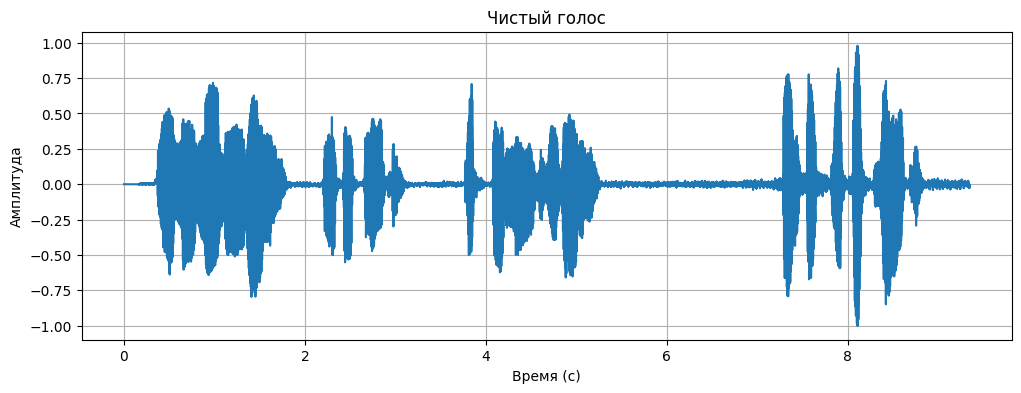

In [298]:
plot_signal_voice(clean_voice, sr, 'Чистый голос')

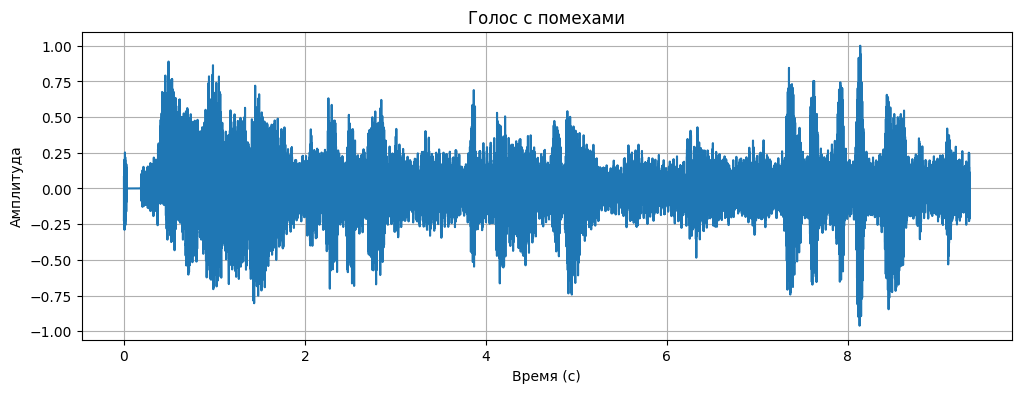

In [299]:
plot_signal_voice(voice_with_noise, sr, 'Голос с помехами')

## **Спектр мощности чистого голоса и голоса с помехами**

In [300]:
def compute_power_spectrum_by_fft(signal, sr):
    n = len(signal)
    freq = np.fft.rfftfreq(n, d=1/sr)
    fft_values = np.fft.rfft(signal)
    power_spectrum = np.abs(fft_values) ** 2
    return freq, power_spectrum

In [301]:
def plot_power_spectrum(signal, sr, title):
    # compute FFT
    freq, power_spectrum = compute_power_spectrum_by_fft(signal, sr)
    # Convert power spectrum to dB
    power_spectrum_db = 10 * np.log10(power_spectrum)
    # plot
    plt.figure(figsize=(12, 6))
    plt.plot(freq, power_spectrum_db)
    plt.title(title)
    plt.xlabel('Частота (Гц)')
    plt.ylabel('Спектр мощности (дБ)')
    plt.grid()
    plt.show()

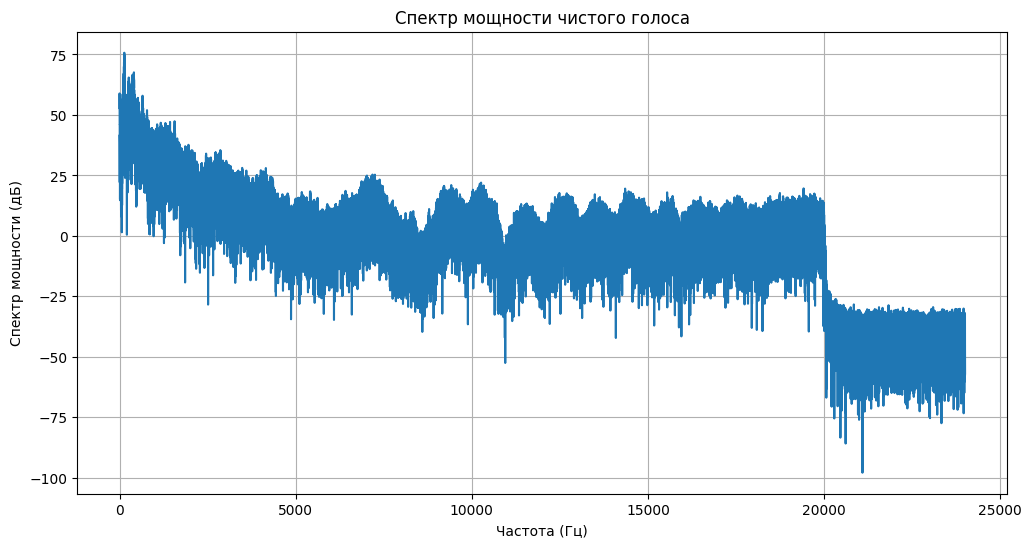

In [302]:
plot_power_spectrum(clean_voice, sr, 'Спектр мощности чистого голоса')

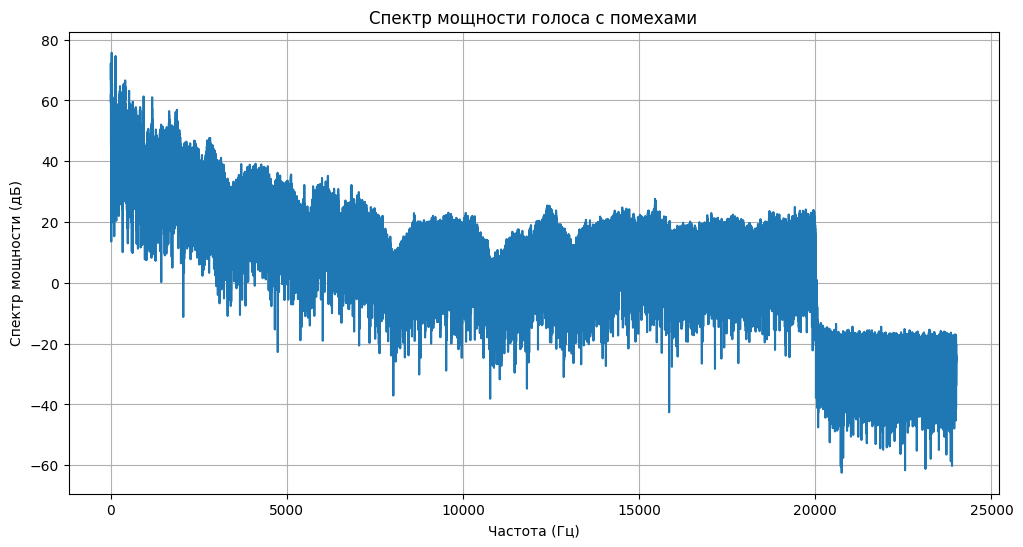

In [303]:
plot_power_spectrum(voice_with_noise, sr, "Спектр мощности голоса с помехами")

# **Подсчёт корреляции двух аудиозаписей**

In [304]:
def compute_correlation(x, y):
    x0 = x.astype(float) - np.mean(x)
    y0 = y.astype(float) - np.mean(y)
    x_norm = x0 / np.linalg.norm(x0)
    y_norm = y0 / np.linalg.norm(y0)
    corr = signal.correlate(y_norm, x_norm, mode='full')
    lags = signal.correlation_lags(len(y_norm), len(x_norm), mode='full')
    return lags, corr

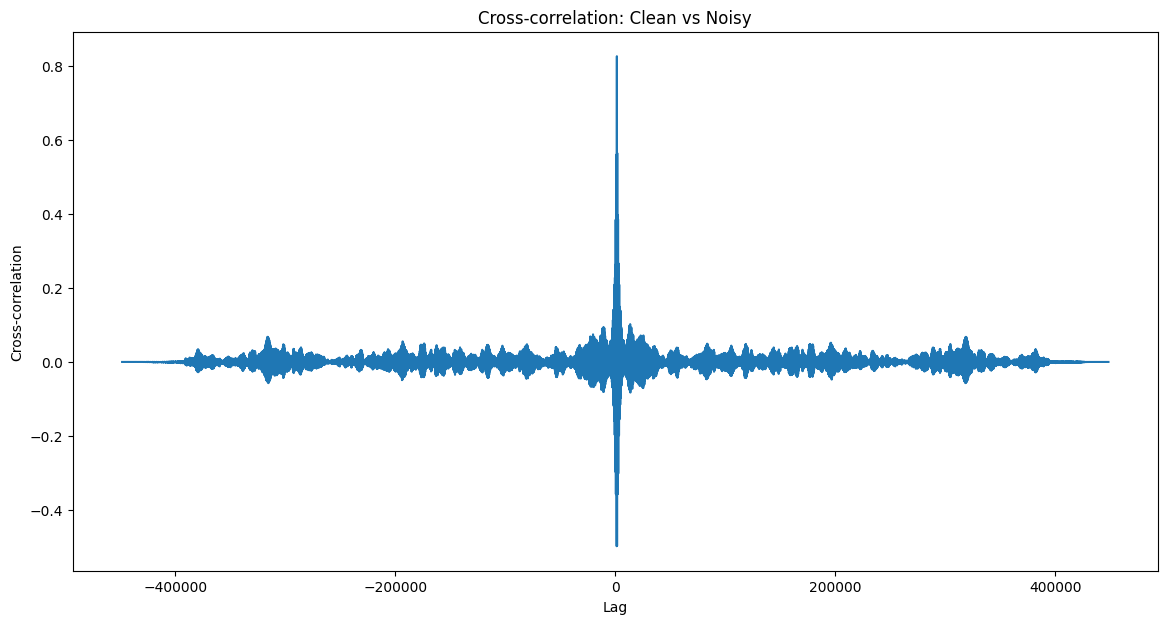

Максимальная корреляция при сдвиге: 1440 отсчётов (0.03 секунд)
Максимум после нормализации: 0.8270


In [305]:
min_len = min(len(clean_voice), len(voice_with_noise))

lags_cn, corr_cn = compute_correlation(clean_voice[:min_len], voice_with_noise[:min_len])
plt.figure(figsize=(14, 7))
plt.plot(lags_cn, corr_cn)
plt.xlabel('Lag')
plt.ylabel('Cross-correlation')
plt.title('Cross-correlation: Clean vs Noisy')
plt.show()

bestLag = lags_cn[np.argmax(corr_cn)]
print(f"Максимальная корреляция при сдвиге: {bestLag} отсчётов ({bestLag/sr} секунд)")
print(f"Максимум после нормализации: {np.max(corr_cn):.4f}")

In [306]:
voice_with_noise = generate_noisy_signal(clean_voice, sr, "input_lab5/background_noise.wav", noise_level=0.6, offset_ms=30, save_path="input_lab5/voice_with_noise.wav")

# **Исследуем диапазоны частот: 90-180 Гц, 180-355 Гц, 355-710 Гц, 710-1400 Гц, 1400-2800 Гц, 2800-5600 Гц, 5600-11200 Гц. Заметка: опорные частоты для этих диапазонов - 125, 250, 500, 1000, 2000, 4000, 8000 Гц**

In [307]:
def analyze_frequency_bands(signal, sr, bands):
    results = {}
    freq, power_spectrum = compute_power_spectrum_by_fft(signal, sr)
    power_spectrum_db = 10 * np.log10(power_spectrum) # Преобразуем в децибелы

    for (low, high) in bands:
        mask = (freq >= low) & (freq <= high)
        band_power = np.mean(power_spectrum_db[mask])
        band_name = f"{low}-{high} Гц"
        results[band_name] = band_power

    return results

In [308]:
def plot_frequency_bands(signal, sr, bands, colors):
    freq, power_spectrum = compute_power_spectrum_by_fft(signal, sr)
    plt.figure(figsize=(14, 7))
    plt.plot(freq, 10 * np.log10(power_spectrum), color='yellow', label='Спектр мощности голоса (дБ)')

    for (fMin, fMax), color in zip(bands, colors):
        plt.axvspan(fMin, fMax, color=color, alpha=0.6, label=f"{fMin}-{fMax} Гц")

    plt.xlabel("Частота (Гц)")
    plt.ylabel("Мощность (дБ)")
    plt.title("Спектр мощности голоса с отмеченными диапазонами")
    plt.grid()
    plt.legend()
    plt.show()

In [309]:
bands = [
    (90, 180),
    (180, 355),
    (355, 710),
    (710, 1400),
    (1400, 2800),
    (2800, 5600),
    (5600, 11200)
]

colors = ['#FF9999', '#FFCC99', '#FFFF99', '#CCFF99', '#99FF99', '#99FFFF', '#9999FF']

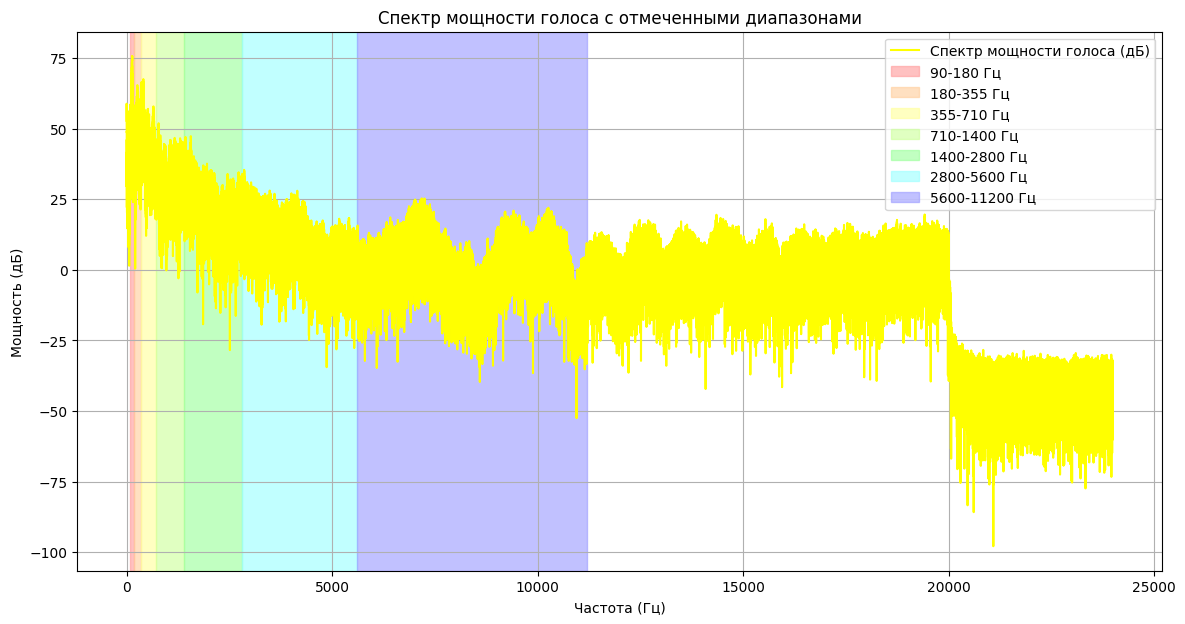

In [310]:
plot_frequency_bands(clean_voice, sr, bands, colors)

In [311]:
clean_bands = analyze_frequency_bands(clean_voice, sr, bands)
noisy_bands = analyze_frequency_bands(voice_with_noise, sr, bands)

print("\nАнализ частотных диапазонов для чистой записи:")
for band, power in clean_bands.items():
    print(f"{band}: {power:.2f}")

print("\nАнализ частотных диапазонов для зашумленной записи:")
for band, power in noisy_bands.items():
    print(f"{band}: {power:.2f}")

print("\nГолос содержится в основном в диапазоне 90-180 Гц (мужской голос)")


Анализ частотных диапазонов для чистой записи:
90-180 Гц: 53.48
180-355 Гц: 49.35
355-710 Гц: 44.66
710-1400 Гц: 34.03
1400-2800 Гц: 24.14
2800-5600 Гц: 11.19
5600-11200 Гц: 3.58

Анализ частотных диапазонов для зашумленной записи:
90-180 Гц: 53.00
180-355 Гц: 48.65
355-710 Гц: 47.06
710-1400 Гц: 38.99
1400-2800 Гц: 35.98
2800-5600 Гц: 24.26
5600-11200 Гц: 10.53

Голос содержится в основном в диапазоне 90-180 Гц (мужской голос)


# **Построим спектр мощности "участков молчания" аудиозаписи голоса**

In [312]:
def extract_background(x, fs, frame_len=0.04, rms_thresh=0.01):
    frame_size = int(frame_len * fs)
    n_frames = len(x) // frame_size

    bg_frames = []
    for i in range(n_frames):
        start = i * frame_size
        end   = start + frame_size
        frame = x[start:end]

        rms = np.sqrt(np.mean(frame**2))
        if rms < rms_thresh:
            bg_frames.append(frame)

    if not bg_frames:
        return np.array([], dtype=x.dtype)

    bg = np.concatenate(bg_frames)
    return bg

In [313]:
silence_clean = extract_background(clean_voice, sr, rms_thresh=0.01)
wav.write("output_lab5/bg_clean.wav", sr, (silence_clean * 32767).astype(np.int16))

In [314]:
# sd.play(silence_clean, sr)
# sd.wait()

In [315]:
shift = bestLag # 30 ms
voice_with_noise_ = np.roll(voice_with_noise, -shift)

silence_noisy = extract_background(voice_with_noise_, sr, rms_thresh = 0.1)
wav.write("output_lab5/bg_noise.wav", sr, (silence_noisy * 32767).astype(np.int16))

In [316]:
# sd.play(silence_noisy, sr)
# sd.wait()

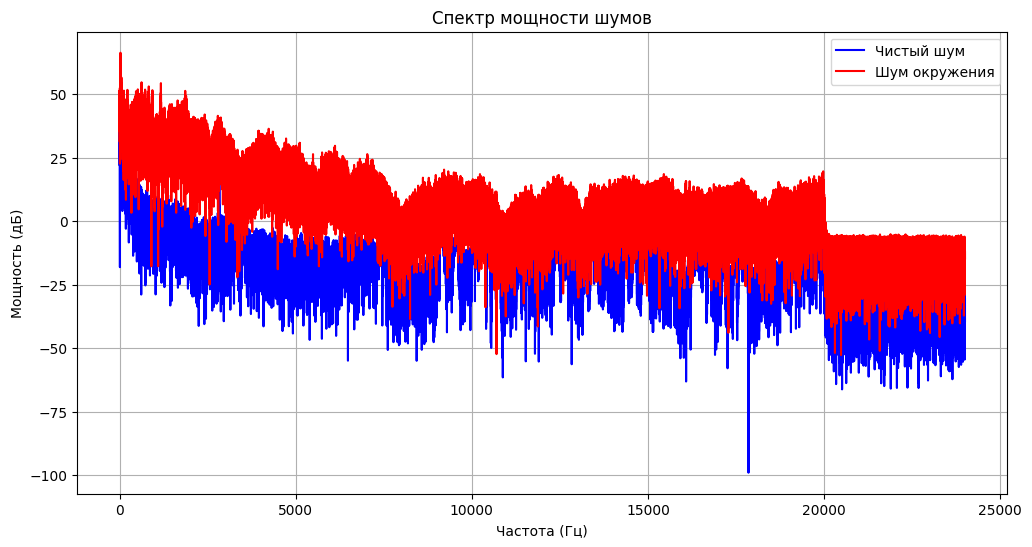

In [317]:
f_clean, P_clean = compute_power_spectrum_by_fft(silence_clean, sr)
f_noisy, P_noisy = compute_power_spectrum_by_fft(silence_noisy, sr)

plt.figure(figsize=(12, 6))
plt.plot(f_clean, 10 * np.log10(P_clean + 1e-10), label='Чистый шум', color='blue')
plt.plot(f_noisy, 10 * np.log10(P_noisy  + 1e-10), label='Шум окружения', color='red')
plt.title('Спектр мощности шумов')
plt.xlabel('Частота (Гц)')
plt.ylabel('Мощность (дБ)')
plt.grid()
plt.legend()
plt.show()

# **Оценка амплитуды шумов на каждом из частотных диапазонов**

In [318]:
bg_silence_clean_bands = analyze_frequency_bands(silence_clean, sr, bands)
bg_silence_noisy_bands = analyze_frequency_bands(silence_noisy, sr, bands)

print("\nАнализ частотных диапазонов для участков молчания чистой записи:")
for band, power in bg_silence_clean_bands.items():
    print(f"{band}: {power:.2f}")

print("\nАнализ частотных диапазонов для участков молчания зашумленной записи:")
for band, power in bg_silence_noisy_bands.items():
    print(f"{band}: {power:.2f}")



Анализ частотных диапазонов для участков молчания чистой записи:
90-180 Гц: 22.76
180-355 Гц: 17.41
355-710 Гц: 5.87
710-1400 Гц: -0.36
1400-2800 Гц: -6.60
2800-5600 Гц: -12.64
5600-11200 Гц: -17.56

Анализ частотных диапазонов для участков молчания зашумленной записи:
90-180 Гц: 39.79
180-355 Гц: 35.30
355-710 Гц: 37.50
710-1400 Гц: 32.67
1400-2800 Гц: 31.21
2800-5600 Гц: 19.89
5600-11200 Гц: 6.63


# **Реализование алгоритма спектрального вычитания для проведения шумоочистки второй аудиозаписи**

##  Вычисляем средний спектр шума

In [319]:
def extract_noise_profile(silence_noisy, fs, fft_size=2048):
    """
    Từ nền tiếng ồn silence_noisy đã tách từ audio, tính profile (phổ trung bình) của nó.
    Trả về noise_fft (dạng vector amplitude) kích thước fft_size//2+1.
    """
    if len(silence_noisy) < fft_size:
        # Nếu không đủ một khung FFT, trả về vectơ 0
        return np.zeros(fft_size//2 + 1)

    # Chia thành các khung, áp cửa sổ Hamming rồi tính FFT
    n_frames = len(silence_noisy) // fft_size
    noise_fft = np.zeros(fft_size//2 + 1)
    for i in range(n_frames):
        frame = silence_noisy[i*fft_size:(i+1)*fft_size]
        windowed = frame * np.hamming(fft_size)
        spectrum = np.abs(np.fft.fft(windowed, n=fft_size)[:fft_size//2 + 1] )
        noise_fft += spectrum

    # Chia cho số khung để được phổ trung bình
    noise_fft /= n_frames
    return noise_fft

## Вычисление параметров фрейм и окна

In [320]:
def get_frame_config(fs, frame_size_sec=0.04, overlap=0.5):
    frame_len = int(fs * frame_size_sec)
    hop_size = int(frame_len * (1 - overlap))
    fft_size = 2 ** int(np.ceil(np.log2(frame_len)))
    window = np.hamming(frame_len)

    return frame_len, hop_size, fft_size, window

## Гарантия noise_profile имеет размер длины fft//2+1

In [321]:
def pad_noise_profile(noise_profile, fft_size):
    needed = fft_size // 2 + 1
    mag = noise_profile[:needed]
    if len(mag) < needed:
        mag = np.pad(mag, (0, needed - len(mag)), mode='constant')
    return mag

## Применить FFT, спектральное вычитание и IFFT к фрейму

In [322]:
def process_frame(frame, window, fft_size, noise_mag):
    # 1) Áp cửa sổ và FFT
    windowed = frame * window
    F = np.fft.fft(windowed, n=fft_size)

    # 2) Lấy biên độ và pha dải một chiều
    half = fft_size // 2 + 1
    mag = np.abs(F[:half])
    phase = np.angle(F[:half])

    # 3) Spectral subtraction
    cleaned_mag = np.maximum(mag - noise_mag, 0)

    # 4) Khôi phục phổ đối xứng
    full = np.zeros(fft_size, dtype=complex)
    full[:half] = cleaned_mag * np.exp(1j * phase)
    full[half:] = np.conj(full[1:half-1][::-1])

    # 5) IFFT và cắt về độ dài frame
    cleaned_frame = np.real(np.fft.ifft(full))[:len(frame)]
    return cleaned_frame

## Overlap-add для реконструкции сигнала из обработанных фреймов

In [323]:
def overlap_add(frames, frame_length, hop_length, window):
    n_frames = len(frames)
    out_len = (n_frames - 1) * hop_length + frame_length
    out = np.zeros(out_len)
    wsum = np.zeros(out_len)
    for i, frm in enumerate(frames):
        start = i * hop_length
        out[start:start + frame_length] += frm * window
        wsum[start:start + frame_length] += window**2
    # chuẩn hóa để tránh thay đổi biên độ
    nonzero = wsum > 1e-8
    out[nonzero] /= wsum[nonzero]
    return out

## Выполнить спектральное вычитание для всего сигнала

In [324]:
def spectral_subtraction(noisy_audio, noise_profile, fs, frame_size_sec=0.04, overlap=0.5):
    # 1) Khởi tạo tham số
    frame_length, hop_length, fft_size, window = get_frame_config(
        fs, frame_size_sec, overlap)
    noise_mag = pad_noise_profile(noise_profile, fft_size)

    # 2) Cắt frame và xử lý
    frames = []
    for start in range(0, len(noisy_audio) - frame_length + 1, hop_length):
        frame = noisy_audio[start:start + frame_length]
        cleaned = process_frame(frame, window, fft_size, noise_mag)
        frames.append(cleaned)

    # 3) Overlap-add
    processed = overlap_add(frames, frame_length, hop_length, window)

    # 4) Cắt phần dư nếu dài hơn
    processed = processed[:len(noisy_audio)]
    return processed

In [325]:
shift = bestLag # 30 ms
voice_with_noise_ = np.roll(voice_with_noise, -shift)

silence_noisy = extract_background(voice_with_noise, sr, rms_thresh = 0.1)

In [326]:
noise_profile = extract_noise_profile(silence_noisy, sr)

In [327]:
cleaned_voice = spectral_subtraction(voice_with_noise_, noise_profile, sr)
wav.write("output_lab5/cleaned_voice.wav", sr, (cleaned_voice * 32767).astype(np.int16))

In [328]:
sd.play(cleaned_voice, sr)
sd.wait()

<sounddevice.CallbackFlags: output underflow>

In [329]:
sd.play(voice_with_noise, sr)
sd.wait()

<sounddevice.CallbackFlags: output underflow>

## Построим спектр мощности очищенной аудиозаписи. Сравним с исходным.

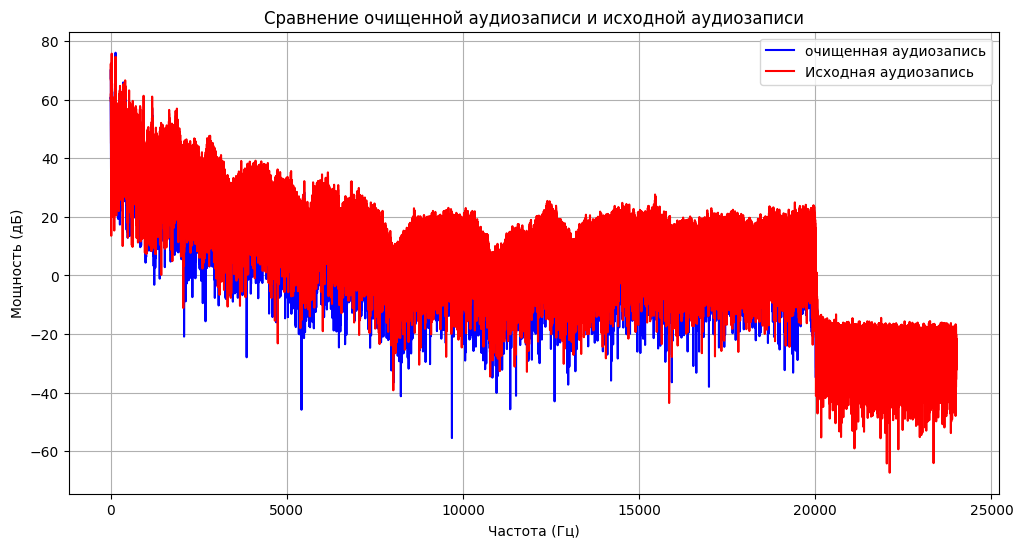

In [330]:
f_voice_noise, P_voice_noise = compute_power_spectrum_by_fft(voice_with_noise, sr)
f_cleaned, P_cleaned = compute_power_spectrum_by_fft(cleaned_voice, sr)

plt.figure(figsize=(12, 6))
plt.plot(f_cleaned, 10 * np.log10(P_cleaned + 1e-10), label='очищенная аудиозапись', color='blue')
plt.plot(f_voice_noise, 10 * np.log10(P_voice_noise  + 1e-10), label='Исходная аудиозапись', color='red')
plt.title('Сравнение очищенной аудиозаписи и исходной аудиозаписи')
plt.xlabel('Частота (Гц)')
plt.ylabel('Мощность (дБ)')
plt.grid()
plt.legend()
plt.show()

## Построим корреляцию третьего (очищенного) сигнала с первым и вторым

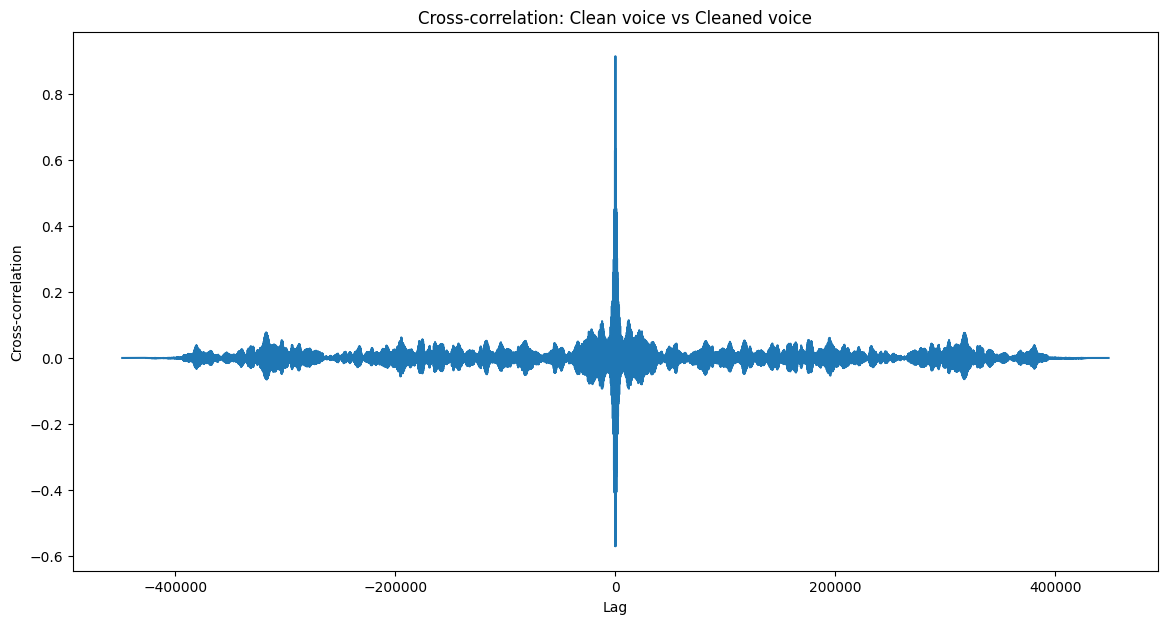

Максимальная корреляция при сдвиге: 0 отсчётов (0.0 секунд)
Максимум после нормализации: 0.9128


In [331]:
min_len = min(len(clean_voice), len(cleaned_voice))

lags_cn, corr_cn = compute_correlation(clean_voice[:min_len], cleaned_voice[:min_len])
plt.figure(figsize=(14, 7))
plt.plot(lags_cn, corr_cn)
plt.xlabel('Lag')
plt.ylabel('Cross-correlation')
plt.title('Cross-correlation: Clean voice vs Cleaned voice')
plt.show()

bestLag = lags_cn[np.argmax(corr_cn)]
print(f"Максимальная корреляция при сдвиге: {bestLag} отсчётов ({bestLag/sr} секунд)")
print(f"Максимум после нормализации: {np.max(corr_cn):.4f}")

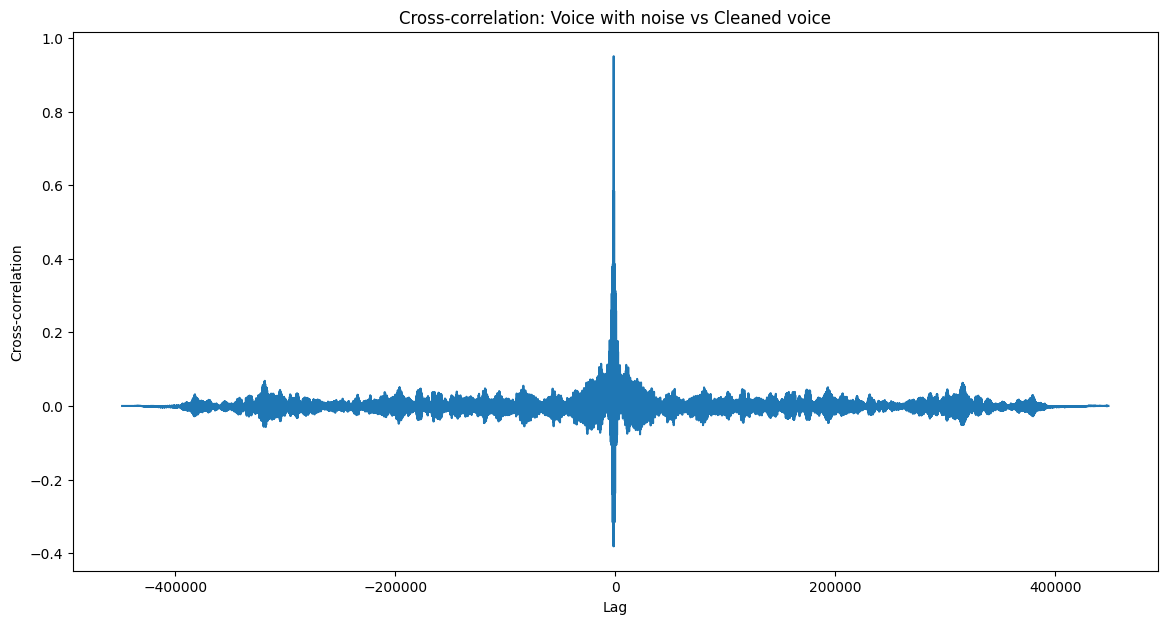

Максимальная корреляция при сдвиге: -1440 отсчётов (-0.03 секунд)
Максимум после нормализации: 0.9507


In [332]:
min_len = min(len(voice_with_noise), len(cleaned_voice))

lags_cn, corr_cn = compute_correlation(voice_with_noise[:min_len], cleaned_voice[:min_len])
plt.figure(figsize=(14, 7))
plt.plot(lags_cn, corr_cn)
plt.xlabel('Lag')
plt.ylabel('Cross-correlation')
plt.title('Cross-correlation: Voice with noise vs Cleaned voice')
plt.show()

bestLag = lags_cn[np.argmax(corr_cn)]
print(f"Максимальная корреляция при сдвиге: {bestLag} отсчётов ({bestLag/sr} секунд)")
print(f"Максимум после нормализации: {np.max(corr_cn):.4f}")

# **Оценка словесной разборчивости сигналов усовершенствованным методом Покровского по 20 равновероятным полосам для русского языка**

In [333]:
# Функция оценки разборчивости по методу Покровского (без встроенных фильтров)
def bandpass_fft(sig, fs, low, high):
    # БПИФ преобразование
    S = np.fft.rfft(sig)
    freqs = np.fft.rfftfreq(len(sig), d=1/fs)
    # маска полосы
    mask = (freqs >= low) & (freqs <= high)
    # обнуляем вне полосы
    S_bp = S * mask
    return np.fft.irfft(S_bp, n=len(sig))

In [334]:
def evaluate_intelligibility(speech, noise, fs):
    bands = [
        (100, 420), (420, 570), (570, 710), (710, 865), (865, 1030),
        (1030, 1220), (1220, 1410), (1410, 1600), (1600, 1780), (1780, 1960),
        (1960, 2140), (2140, 2320), (2320, 2550), (2550, 2900), (2900, 3300),
        (3300, 3660), (3660, 4050), (4050, 5010), (5010, 7250), (7250, 10000)
    ]

    AI_sum = 0.0
    N = len(speech)
    for (low, high) in bands:
        # полосовая фильтрация через FFT
        sp = bandpass_fft(speech, fs, low, high)
        ns = bandpass_fft(noise, fs, low, high)
        # пиковый уровень речи в полосе
        peak = np.max(np.abs(sp)) + 1e-12
        B_r = 20 * np.log10(peak)
        # эффективный уровень шума (RMS)
        rms_n = np.sqrt(np.mean(ns**2)) + 1e-12
        B_n = 20 * np.log10(rms_n)
        deltaL = B_r - B_n
        # вероятность восприятия P(E'_k)
        if deltaL <= 0:
            P = 0.0
        elif deltaL >= 30:
            P = 1.0
        else:
            P = deltaL / 30.0
        AI_sum += P
    # усреднение по 20 полосам (p_k = 1/20)
    AI = AI_sum / len(bands)
    return AI

In [335]:
denoised_noise = extract_background(cleaned_voice, sr, rms_thresh = 0.1)

int_clean = evaluate_intelligibility(clean_voice, silence_clean, sr)
int_noisy = evaluate_intelligibility(voice_with_noise, silence_noisy, sr)
int_denoised = evaluate_intelligibility(cleaned_voice, denoised_noise, sr)

print(f"Индекс артикуляции (AI) для чистой записи: {int_clean:.3f}")
print(f"Индекс артикуляции (AI) для зашумлённой записи: {int_noisy:.3f}")
print(f"Индекс артикуляции (AI) для очищенной записи: {int_denoised:.3f}")

Индекс артикуляции (AI) для чистой записи: 1.000
Индекс артикуляции (AI) для зашумлённой записи: 0.672
Индекс артикуляции (AI) для очищенной записи: 0.752
